In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
clean= pd.read_csv("cleaned_churndata.csv")
clean_org= clean.copy()

In [4]:
clean

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,OnlineBackup_No internet service,OnlineBackup_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,45,0,0,42.30,1840.75,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,0,1,1,24,1,1,84.80,1990.50,0,...,1,0,1,1,0,0,0,0,0,1
7028,1,0,1,1,72,1,1,103.20,7362.90,0,...,1,0,1,1,0,0,1,1,0,0
7029,1,0,1,1,11,0,1,29.60,346.45,0,...,0,0,0,0,0,0,0,0,1,0
7030,0,1,1,0,4,1,1,74.40,306.60,1,...,0,0,0,0,0,0,0,0,0,1


In [5]:
X= clean.drop("Churn", axis=1)
Y= clean['Churn']

In [6]:
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.2, random_state= 42, stratify=Y )

Training the model using GridsearchCV

first creating a parameters grid

In [7]:
'''tree= RandomForestClassifier(n_estimators= 100,max_depth= None, random_state= 42, class_weight= "balanced")'''
param_grid={
    'n_estimators': [100,200],
    'max_depth': [10,20,None],
    'min_samples_split':[2, 5],
    'class_weight': ['balanced']
}


In [8]:
tree=RandomForestClassifier(random_state=42)

grid_search= GridSearchCV(estimator=tree,
                          param_grid= param_grid,
                          cv= 5, #5 fold cross validation
                          scoring= "roc_auc",#focus
                          n_jobs= -1, #use all cores
                          verbose=2) #seeing progress

In [9]:
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

Checking best parameters

In [10]:
print('best parameters')
print(grid_search.best_params_)

print('best roc and auc')
print(grid_search.best_score_)

best parameters
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
best roc and auc
0.8452079976029866


Using the best parameters for prediction

In [11]:
best_rf= grid_search.best_estimator_

In [12]:
y_pred= best_rf.predict(X_test)

In [13]:
print("Confusion matrix\n",pd.DataFrame(confusion_matrix(Y_test, y_pred), 
                                        index= ["Actual- not churned","Actual- churned"],
                                        columns= ["Predicted- not churned", "Predicted- churned" ]))
print("Classification report\n", classification_report(Y_test, y_pred))
print("roc and auc score\n", roc_auc_score(Y_test, y_pred))

Confusion matrix
                      Predicted- not churned  Predicted- churned
Actual- not churned                     801                 232
Actual- churned                          96                 278
Classification report
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      1033
           1       0.55      0.74      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407

roc and auc score
 0.7593634655305402


<Axes: title={'center': 'Top 15 Features'}>

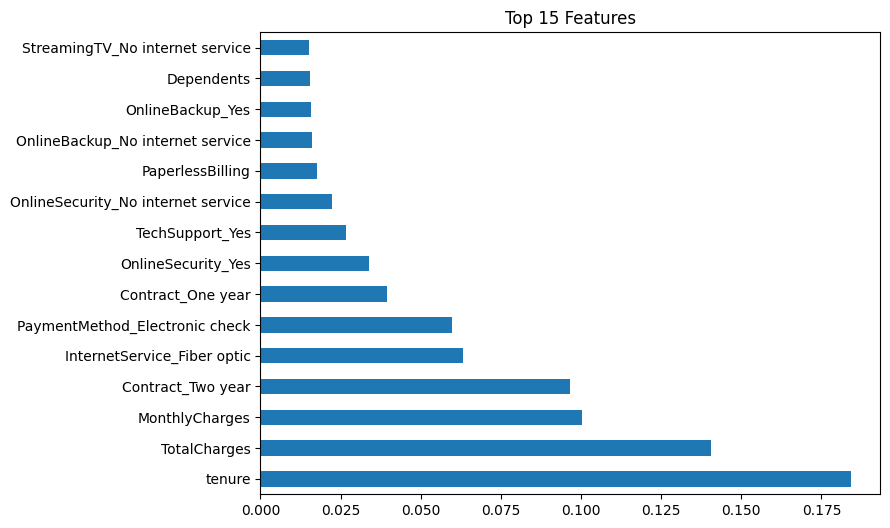

In [14]:
importances= pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind='barh', figsize=(8,6), title= 'Top 15 Features')

In [15]:
'''import joblib

joblib.dump(best_rf,"churn_model")'''

'import joblib\n\njoblib.dump(best_rf,"churn_model")'

In [16]:
'''X_test_copy= X_test.copy()
X_test_copy['Actual values']= Y_test
X_test_copy['Predicted values']= best_rf.predict(X_test)
X_test_copy['Churned Probablities']= best_rf.predict_proba(X_test)[:,1]

X_test_copy.to_csv('Churn_predictions.csv', index=False)'''

"X_test_copy= X_test.copy()\nX_test_copy['Actual values']= Y_test\nX_test_copy['Predicted values']= best_rf.predict(X_test)\nX_test_copy['Churned Probablities']= best_rf.predict_proba(X_test)[:,1]\n\nX_test_copy.to_csv('Churn_predictions.csv', index=False)"

In [17]:
importances.sort_values(ascending=False).head(10).to_csv("feature_importance.csv")